In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans as SKLearnKMeans
from KMeansPy import KMeansPy

In [2]:
# Set random seed for reproducibility
np.random.seed(78)

# Generate synthetic data
k = 5  # number of clusters
p = 512  # feature dimensions
n = 5000  # number of samples

# Generate true cluster centers
centers_true = np.random.randn(k, p)  

# Generate data
X = np.zeros((n, p))  
for ki in range(k):
    start_idx = ki * n // k
    end_idx = (ki + 1) * n // k
    # Modify data generation to make each sample a row
    X[start_idx:end_idx, :] = centers_true[ki, :] + 0.1 * np.random.randn(n // k, p)

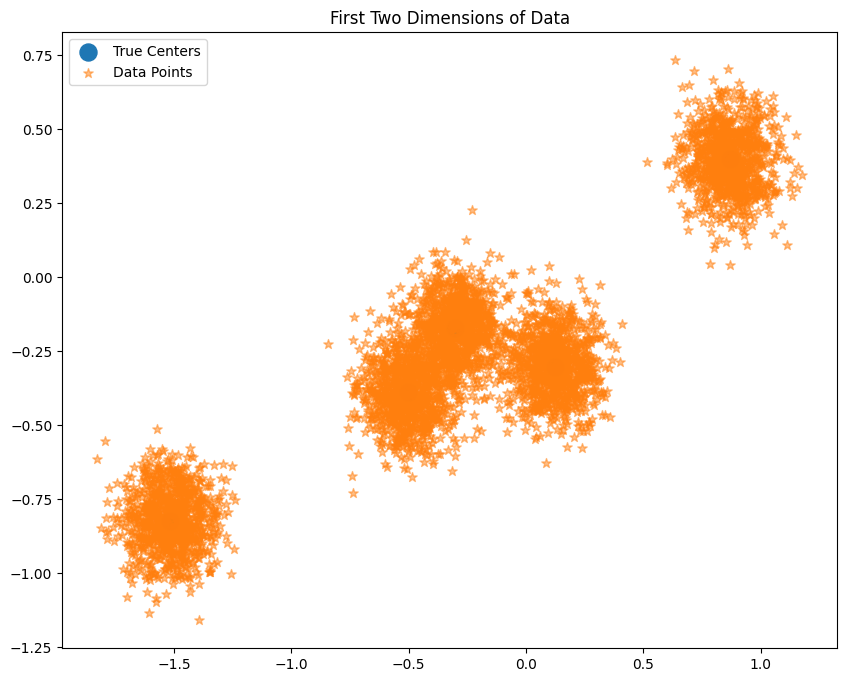

In [3]:
# Visualize first two dimensions of the data
plt.figure(figsize=(10, 8))
plt.scatter(centers_true[:, 0], centers_true[:, 1], marker='o', s=150, label='True Centers')
plt.scatter(X[:, 0], X[:, 1], marker='*', s=50, alpha=0.5, label='Data Points')
plt.title('First Two Dimensions of Data')
plt.legend()
plt.show()

In [4]:
n_replicates = 20  
np.random.seed(78)
initial_centers = X[np.random.choice(n, k, replace=False)]

In [5]:
# # 1. scikit-learn KMeans version
# start_time = time.time()
# sklearn_kmeans = SKLearnKMeans(n_clusters=k, init=initial_centers, n_init=n_replicates, max_iter=300)
# sklearn_kmeans.fit(X)  # X is in (n, p) format, pass directly
# time_sklearn = time.time() - start_time
# centers_sklearn = sklearn_kmeans.cluster_centers_
# obj_sklearn = sklearn_kmeans.inertia_
# print(f'scikit-learn version:\tObjective value {obj_sklearn:.3e}, Runtime {time_sklearn:.2e}s')

In [6]:
# 2. Our KMeansPy version (without sparsification)
start_time = time.time()
our_kmeans = KMeansPy(n_components=k, init="random", n_init=n_replicates, max_iter=300,
                      num_samp=n, num_feat_full=p, num_feat_comp=p)  # parameters match X dimensions
our_kmeans.fit(X=X)  # X is in (n, p) format, pass directly
time_our = time.time() - start_time
centers_our = our_kmeans.cluster_centers_
obj_our = our_kmeans.inertia_
print(f'Our version:\t\tObjective value {obj_our:.3e}, Runtime {time_our:.2e}s')

Our version:		Objective value 2.556e+04, Runtime 3.85e+02s


In [7]:
# 3. Our KMeansPy version (with sparsification)
sparsity_level = 0.05  # sparsification level
num_feat_comp = int(p * sparsity_level)  # number of compressed features
start_time = time.time()
sparse_kmeans = KMeansPy(n_components=k, init="random", n_init=n_replicates, max_iter=300,
                        num_samp=n, num_feat_full=p, num_feat_comp=num_feat_comp)
sparse_kmeans.fit(X = X)
time_sparse = time.time() - start_time
centers_sparse = sparse_kmeans.cluster_centers_
obj_sparse = sparse_kmeans.inertia_
print(f'Sparse version (compression {sparsity_level*100:.0f}%):\tObjective value {obj_sparse:.3e}, Runtime {time_sparse:.2e}s')

Sparse version (compression 5%):	Objective value 2.517e+04, Runtime 4.14e+01s


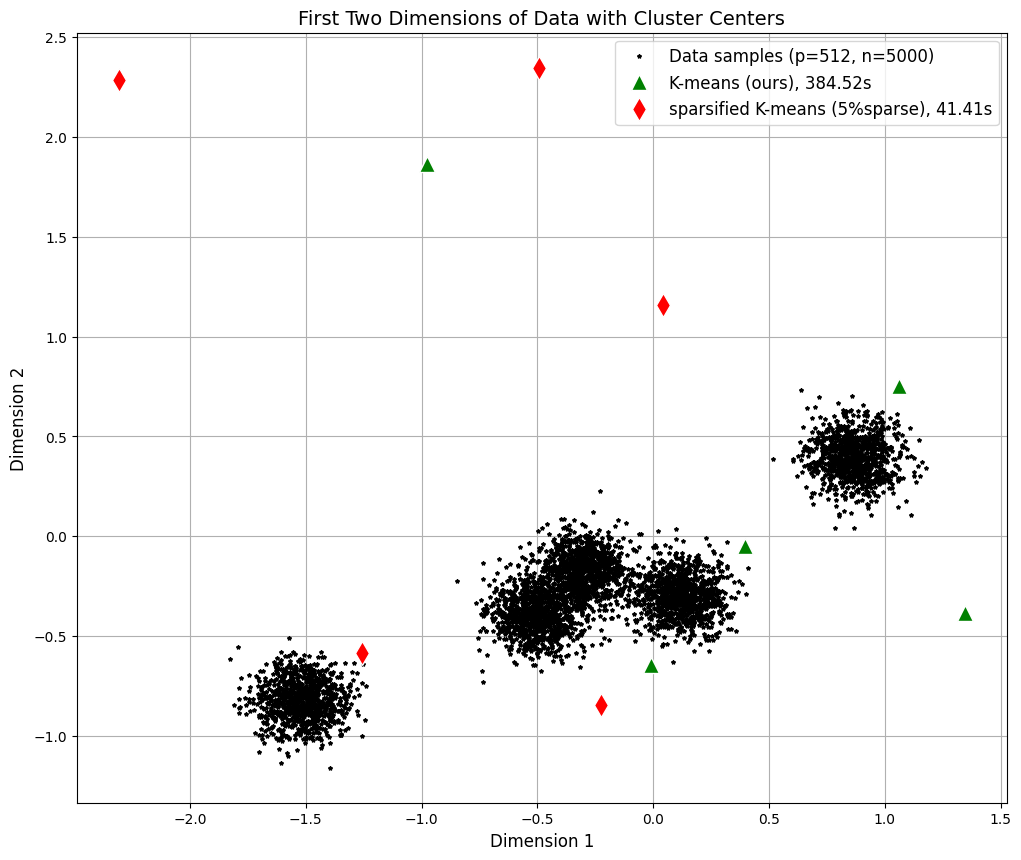

In [8]:
# Visualize results
plt.figure(figsize=(12, 10))

# Plot data points
plt.plot(X[:, 0], X[:, 1], 'k*', markersize=3, label=f'Data samples (p={p}, n={n})')

# # Plot scikit-learn cluster centers
# plt.plot(centers_sklearn[:, 0], centers_sklearn[:, 1], 'ws', markersize=12, 
#          markerfacecolor='b', linewidth=2, label=f'K-means (scikit-learn), {time_sklearn:.2f}s')

# Plot our KMeansPy version cluster centers
plt.plot(centers_our[:, 0], centers_our[:, 1], 'w^', markersize=12, 
         markerfacecolor='g', linewidth=2, label=f'K-means (ours), {time_our:.2f}s')

# Plot sparsified version cluster centers
plt.plot(centers_sparse[:, 0], centers_sparse[:, 1], 'wd', markersize=12, 
         markerfacecolor='r', linewidth=2, label=f'sparsified K-means ({sparsity_level*100:.0f}%sparse), {time_sparse:.2f}s')

plt.grid(True)
plt.legend(fontsize=12)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.title('First Two Dimensions of Data with Cluster Centers', fontsize=14)
plt.show()

In [9]:
# Test different compression ratios
sparsity_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
times = []
objectives = []

for sl in sparsity_levels:
    num_feat_comp = max(int(p * sl), 1)  # ensure at least 1 feature
    start_time = time.time()
    sparse_kmeans = KMeansPy(n_components=k, init='kmpp', n_init=n_replicates, max_iter=300,
                            num_samp=n, num_feat_full=p, num_feat_comp=num_feat_comp)
    sparse_kmeans.fit(X=X)
    run_time = time.time() - start_time
    times.append(run_time)
    objectives.append(sparse_kmeans.inertia_)
    print(f'Compression {sl*100:.0f}%: Objective value {sparse_kmeans.inertia_:.3e}, Runtime {run_time:.2f}s')

Compression 1%: Objective value 1.442e+05, Runtime 111.44s
Compression 5%: Objective value 2.517e+04, Runtime 41.07s
Compression 10%: Objective value 2.538e+04, Runtime 63.76s
Compression 20%: Objective value 2.541e+04, Runtime 108.20s
Compression 50%: Objective value 2.554e+04, Runtime 226.90s
Compression 100%: Objective value 2.556e+04, Runtime 319.43s


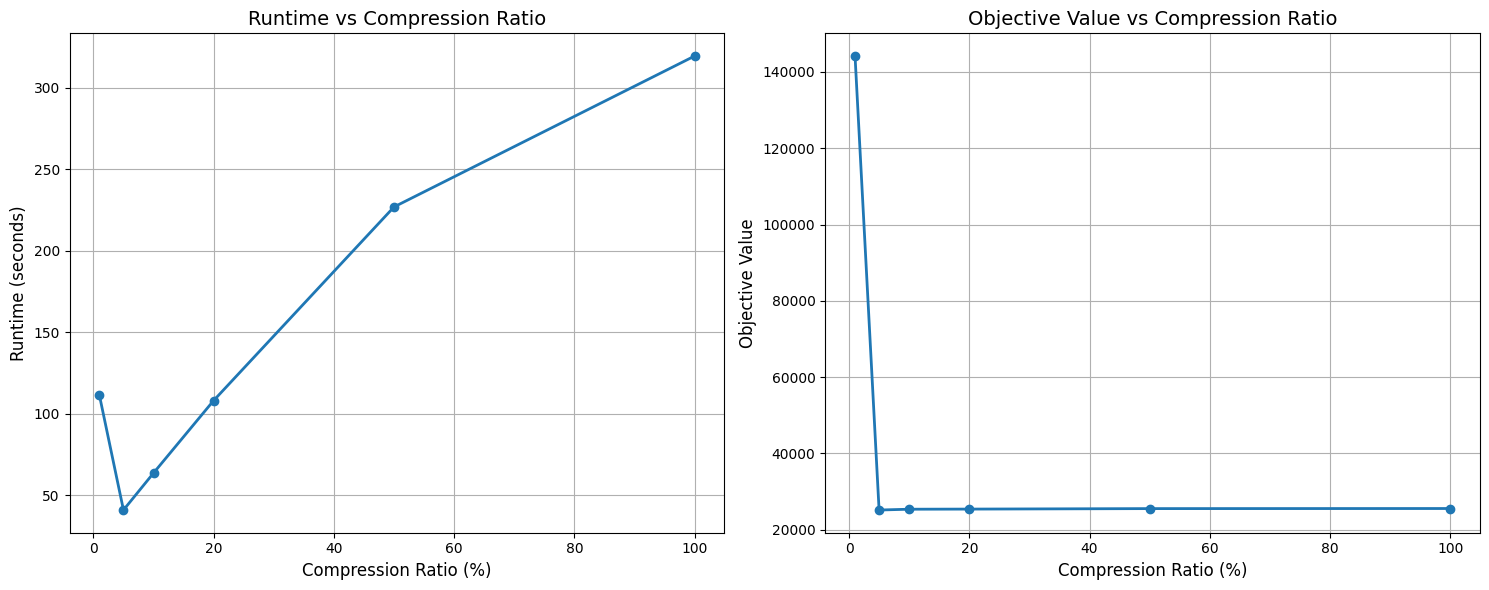

In [10]:
# Plot relationship between compression ratio and performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Runtime plot
ax1.plot(np.array(sparsity_levels)*100, times, 'o-', linewidth=2)
ax1.set_xlabel('Compression Ratio (%)', fontsize=12)
ax1.set_ylabel('Runtime (seconds)', fontsize=12)
ax1.set_title('Runtime vs Compression Ratio', fontsize=14)
ax1.grid(True)

# Objective value plot
ax2.plot(np.array(sparsity_levels)*100, objectives, 'o-', linewidth=2)
ax2.set_xlabel('Compression Ratio (%)', fontsize=12)
ax2.set_ylabel('Objective Value', fontsize=12)
ax2.set_title('Objective Value vs Compression Ratio', fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()

结论:
1. 稀疏化KMeans在保持较好聚类质量的同时，显著减少了计算时间"
2. 随着压缩率的增加，运行时间减少，但目标函数值（聚类质量）可能会略有下降
3. 在高维数据上，即使使用很小的压缩率（如5%），也能获得接近原始算法的聚类结果这表明稀疏化技术在处理大规模高维数据时非常有效，能够在保持结果质量的同时显著提高计算效率